* Check the freshwater transport impact by wind in May.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import wind
import pandas as pd
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':55,  'ist': 1,'jen':56,'ien':25},
            '7':{'jst':25,'ist':1, 'jen':26,'ien':25}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.8, 49.7)

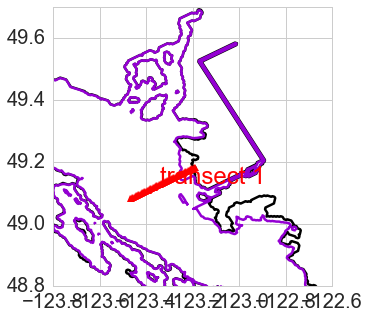

In [5]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.set_xlim([-123.8,-122.6])
ax.set_ylim([48.8,49.7])

In [6]:
## load salinity into a dict
pathsoct = ['Oct2014nowind','Oct2014combineall']
pathsmay = ['May2015nowind','May2015combineall']
pathsjan = ['Jan2016nowind','Jan2016combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = ['oct2014*_T.nc','may2015*_T.nc','jan2016*_T.nc']
file_patternUs = ['oct2014*_U.nc','may2015*_U.nc','jan2016*_U.nc']
file_patternVs = ['oct2014*_V.nc','may2015*_V.nc','jan2016*_V.nc']
U = {}; V={}; S={};ssh = {}
paths = [pathsoct,pathsmay,pathsjan]
for paa,Tfile, Ufile,Vfile in zip(paths,file_patternTs,file_patternUs,file_patternVs):
    for pa in paa:
        print(glob(os.path.join(base,pa, Tfile)))
        pathT = glob(os.path.join(base,pa, Tfile))
        pathU = glob(os.path.join(base,pa, Ufile))
        pathV = glob(os.path.join(base,pa, Vfile))
        fU = nc.Dataset(pathU[0],'r');
        U[pa] = fU.variables['vozocrtx']
        fV = nc.Dataset(pathV[0],'r');
        V[pa] = fV.variables['vomecrty']
        fT = nc.Dataset(pathT[0],'r');
        S[pa] = fT.variables['vosaline']
        lon = fT.variables['nav_lon'] 
        lat = fT.variables['nav_lat']
        ssh[pa] = fT.variables['sossheig']
        time_counter = fT.variables['time_counter']
        depT = fT.variables['deptht']

['/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc']
['/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc']
['/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc']
['/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc']
['/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc']
['/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc']


In [7]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """to calculate the total transport (False)or fresh water transport (True) in the entire water column 
    with focus on a continous time period rather than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st[pa],t_en[pa]+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depT,tran,t_st,t_en,\
                                                 paths,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [18]:
def transport_time_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j+1,1])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,1,i+1])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st[pa]:t_en[pa]+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st[pa]:t_en[pa]+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [9]:
def transportDaily_series(S,U,V,ssh,lon,lat,depT,dep,tran,tst,ten,paths,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for daily case, over selected depths"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 paths,fresh_flag = fresh_flag)
    inte_trans = {}; 
    for ty in paths:
        inte_trans[ty] = np.zeros((ten[ty]-tst[ty]+1)/24)
        for i in np.arange(tst[ty],ten[ty]+1,24): ## intergral individual daily
            inte_trans[ty][i/24-tst[ty]/24] = np.nansum(trans[ty][i:i+24,depT[0]:depT[dep]+1])*3600
    return inte_trans

# get wind results

In [10]:
def get_OPwinds(stationsOP,OPlon,OPlat,filesOP,j,i,duration,sax,eax):
    "This function was made to get model winds' speed and direction"
    wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={};
    solar={}; precip={}; qair={}; lon = {};lat = {};

    for  modOP in stationsOP:   
        
        [j,i]=wind.find_model_point(X[j,i],Y[j,i],OPlon,OPlat)
        lon[modOP] = OPlon[j,i]
        lat[modOP]=OPlat[j,i]
        print(j,i,lon[modOP],lat[modOP])

        [wind_speed[modOP],wind_dir[modOP],time[modOP],
         press[modOP],temp[modOP],solar[modOP],
         therm[modOP],qair[modOP],precip[modOP]] = wind.compile_OP(filesOP,j,i)    
      
    return wind_speed, wind_dir

In [11]:
import glob
X = grid6.variables['nav_lon']
Y = grid6.variables['nav_lat']
OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m05d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m05d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-May-2015'; end = '31-May-2015';
start2 = '31-May-2015'; end2 = '31-May-2015';
endd = '31-May-2015';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedMay,wind_dirMay =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [12]:
## May
wind_dir_correctMay = []
for dire in wind_dirMay['Sandheads_OP']:
    dire_corre = 450 - dire
    wind_dir_correctMay.append(dire_corre)
df_may = pd.DataFrame({"speed": wind_speedMay['Sandheads_OP'], "direction": wind_dir_correctMay})

In [13]:
u_may = np.zeros([1,len(df_may)])
v_may = np.zeros([1,len(df_may)])
for i in np.arange(len(df_may)):
    u_may[0,i] = df_may.speed[i] * np.cos((450-df_may.direction[i])*np.pi/180) ## eastward
    v_may[0,i] = df_may.speed[i] * np.sin((450-df_may.direction[i])*np.pi/180) ## northward

In [14]:
## Oct
import glob
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d*.nc')
filesOP.sort(key=os.path.basename)

OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]

start = '1-Oct-2014'; end = '31-Oct-2014';
start2 = '31-Oct-2014'; end2 = '31-Oct-2014';
endd = '31-Oct-2014';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speed,wind_dir =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                            27,sax,eax)

135 151 -123.302707487 49.0907848354


In [15]:
## convert direction Oct
wind_dir_correct = []
for dire in wind_dir['Sandheads_OP']:
    dire_corre =  450 - dire
    wind_dir_correct.append(dire_corre)
## load into a pandas frame
df_oct = pd.DataFrame({"speed": wind_speed['Sandheads_OP'], "direction": wind_dir_correct})



u_oct = np.zeros([1,len(df_oct)])
v_oct = np.zeros([1,len(df_oct)])
for i in np.arange(len(df_oct)):
    u_oct[0,i] = df_oct.speed[i] * np.cos((450-df_oct.direction[i])*np.pi/180)
    v_oct[0,i] = df_oct.speed[i] * np.sin((450-df_oct.direction[i])*np.pi/180)

In [16]:
## Jan
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2016m01d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-Jan-2016'; end = '31-Jan-2016';
start2 = '31-Jan-2016'; end2 = '31-Jan-2016';
endd = '31-Jan-2016';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedJan,wind_dirJan =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [17]:
## Jan
wind_dir_correctJan = []
for dire in wind_dirJan['Sandheads_OP']:
    dire_corre =  450 - dire 
    wind_dir_correctJan.append(dire_corre)
df_jan = pd.DataFrame({"speed": wind_speedJan['Sandheads_OP'], "direction": wind_dir_correctJan})

u_jan = np.zeros([1,len(df_jan)])
v_jan = np.zeros([1,len(df_jan)])
for i in np.arange(len(df_jan)):
    u_jan[0,i] = df_jan.speed[i] * np.cos((450-df_jan.direction[i])*np.pi/180)
    v_jan[0,i] = df_jan.speed[i] * np.sin((450-df_jan.direction[i])*np.pi/180)

# Calculation

In [19]:
paths = pathsmay
tst = {'May2015nowind':0,'May2015combineall':0}
ten = {'May2015nowind':743,'May2015combineall':743}
inte_weak_May = transportDaily_series(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [20]:
paths = pathsjan
tst = {'Jan2016nowind':0,'Jan2016combineall':0}
ten = {'Jan2016nowind':743,'Jan2016combineall':743}
inte_weak_Jan = transportDaily_series(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [21]:
paths = pathsoct
tst = {'Oct2014nowind':0,'Oct2014combineall':0}
ten = {'Oct2014nowind':743,'Oct2014combineall':743}
inte_weak_Oct = transportDaily_series(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Integral Northward wind component daily

In [30]:
def Integral_V(hours,v_may):
    """
    To integral northward velocity v in hours we define
    """
    v_integral = np.zeros(v_may.shape[1]/hours)
    j = 0
    for i in np.arange(0,v_may.shape[1],hours):
        v_integral[j] = np.sum(v_may[0,i:i+hours])
        j = j +1
    return v_integral

In [31]:
## daily integral
v_inte = Integral_V(24,v_may)

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [32]:
## 6hrs integral
v_inte_6hrs = Integral_V(6,v_may)

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Plot

In [23]:
## for column plot Day 16~19
a = datetime.datetime(2015,5,16,0,30)
b = datetime.datetime(2015,5,19,23,30)

In [24]:
import matplotlib.dates as md
t_daily = [datetime.datetime(2015,5,day,12,30) for day in np.arange(1,32)]
t_wind = [datetime.datetime(2015,5,day,hour, 30) for day in np.arange(1,32) for hour in np.arange(24)]

t_start = datetime.datetime(2015,5,1,0,30)
t_end = datetime.datetime(2015,5,31,23,30)

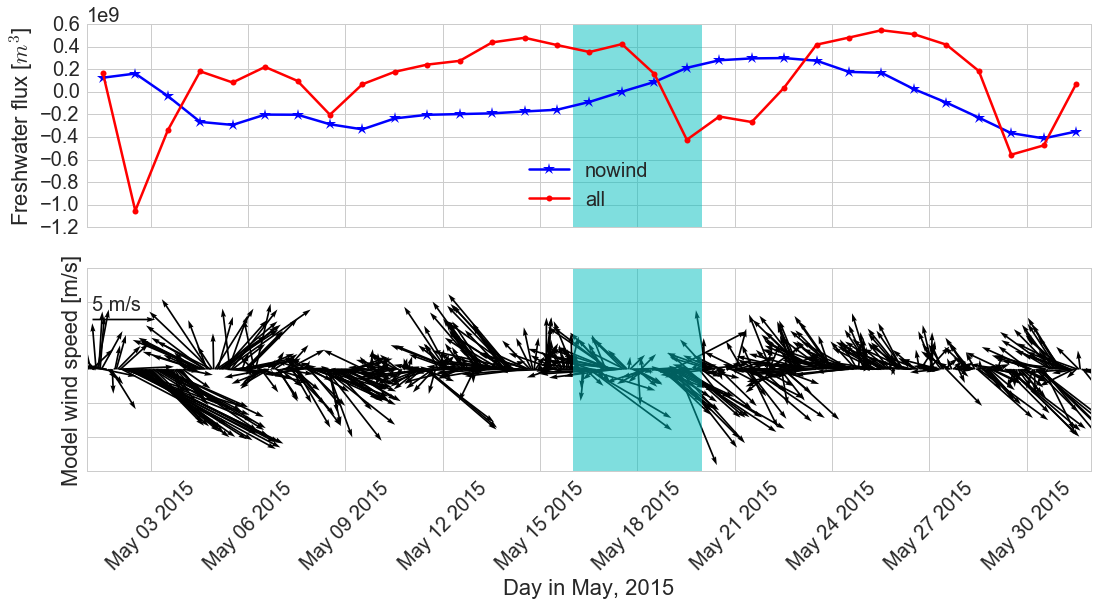

In [21]:
## use metric e3t[transect[j]] not +1
fig,axs = plt.subplots(2,1,figsize = (18,8))
ax = axs[0]
ax.plot(t_daily,inte_weak_May['May2015nowind'],'b*-',markersize = 12,label ='nowind')
ax.plot(t_daily,inte_weak_May['May2015combineall'],'r.-',markersize = 12,label ='all')
ax.legend(loc = 'best')
ax.set_ylabel('Freshwater flux [$m^3$]')
plt.setp(ax.get_xticklabels(), visible=False)
ax = axs[1]
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_may[:],v_may[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03,5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
for ax in axs: ## set xlims
    ax.set_xlim([t_start,t_end])
    ax.axvspan(a, b, color='c', alpha=0.5, lw=0)
ax.set_xlabel('Day in May, 2015')
ax.set_ylabel('Model wind speed [m/s]')
plt.setp(ax.get_yticklabels(), visible=False)
plt.xticks(rotation=45)
plt.show()

In [68]:
## if Day 19~21
a = [datetime.datetime(2015,5,9,0,30),datetime.datetime(2015,5,19,0,30),datetime.datetime(2015,5,2,0,30)]
b = [datetime.datetime(2015,5,11,23,30),datetime.datetime(2015,5,21,23,30),datetime.datetime(2015,5,3,21,30)]

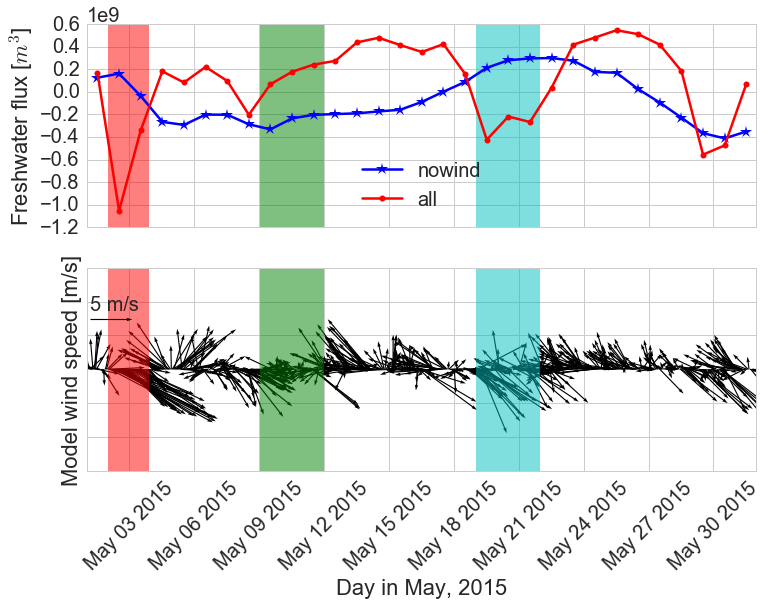

In [69]:
fig,axs = plt.subplots(2,1,figsize = (12,8))
ax = axs[0]
ax.plot(t_daily,inte_weak_May['May2015nowind'],'b*-',markersize = 12,label ='nowind')
ax.plot(t_daily,inte_weak_May['May2015combineall'],'r.-',markersize = 12,label ='all')
ax.legend(loc = 'best')
ax.set_ylabel('Freshwater flux [$m^3$]')
plt.setp(ax.get_xticklabels(), visible=False)
ax = axs[1]
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_may[:],v_may[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03,5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
for i, c in zip(np.arange(3),['g','c','r']):
    for ax in axs: ## set xlims
        ax.set_xlim([t_start,t_end])
        ax.axvspan(a[i], b[i], color=c, alpha=0.5, lw=0)
    plt.xticks(rotation=45)
ax.set_xlabel('Day in May, 2015')
ax.set_ylabel('Model wind speed [m/s]')
plt.setp(ax.get_yticklabels(), visible=False)
plt.xticks(rotation=45)
plt.show()

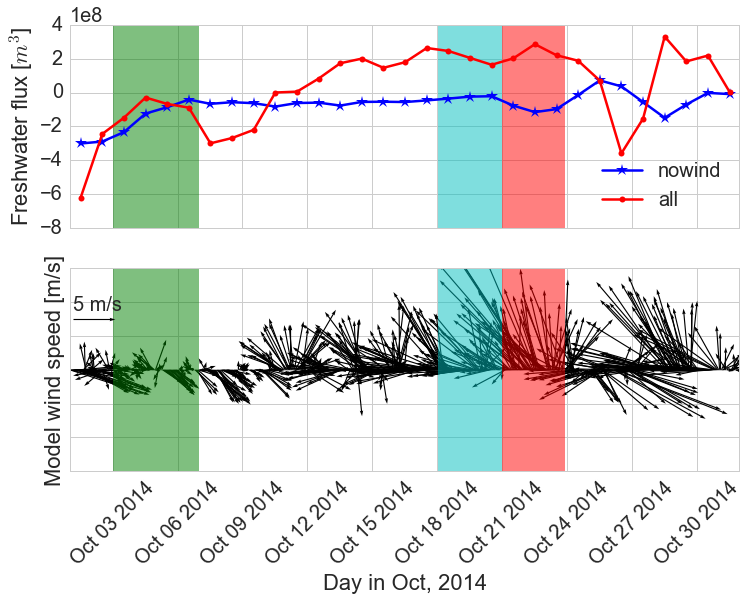

In [25]:
## Oct
t_start = datetime.datetime(2014,10,1,0,30)
t_end = datetime.datetime(2014,10,31,23,30)
t_daily = [datetime.datetime(2014,10,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2014,10,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

a = [datetime.datetime(2014,10,3,0,30),datetime.datetime(2014,10,18,0,30),datetime.datetime(2014,10,21,0,30)]
b = [datetime.datetime(2014,10,6,23,30),datetime.datetime(2014,10,20,23,30),datetime.datetime(2014,10,23,21,30)]

fig,axs = plt.subplots(2,1,figsize = (12,8))
ax = axs[0]
ax.plot(t_daily,inte_weak_Oct['Oct2014nowind'],'b*-',markersize = 12,label ='nowind')
ax.plot(t_daily,inte_weak_Oct['Oct2014combineall'],'r.-',markersize = 12,label ='all')
ax.legend(loc = 'best')
ax.set_ylabel('Freshwater flux [$m^3$]')
plt.setp(ax.get_xticklabels(), visible=False)
ax = axs[1]
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_oct[:],v_oct[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03,5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
for i, c in zip(np.arange(3),['g','c','r']):
    for ax in axs: ## set xlims
        ax.set_xlim([t_start,t_end])
        ax.axvspan(a[i], b[i], color=c, alpha=0.5, lw=0)
    plt.xticks(rotation=45)
ax.set_xlabel('Day in Oct, 2014')
ax.set_ylabel('Model wind speed [m/s]')
plt.setp(ax.get_yticklabels(), visible=False)
plt.xticks(rotation=45)
plt.show()

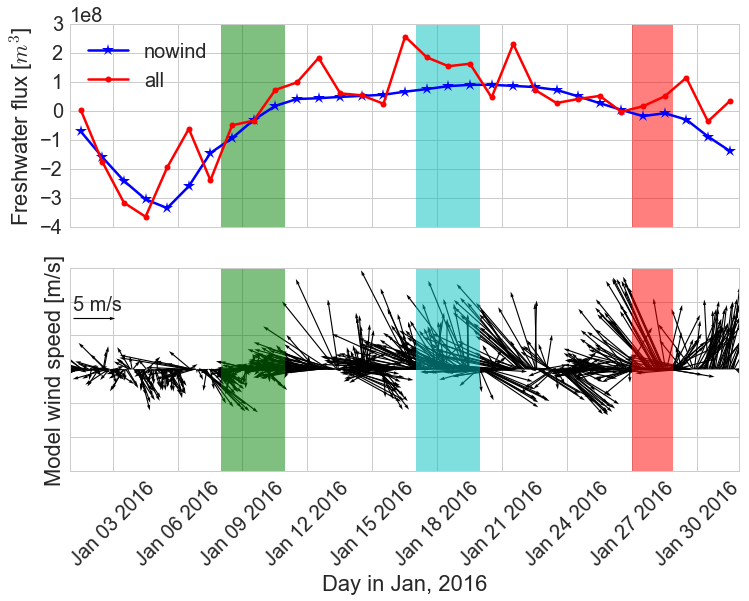

In [26]:
## Jan
t_start = datetime.datetime(2016,1,1,0,30)
t_end = datetime.datetime(2016,1,31,23,30)
t_daily = [datetime.datetime(2016,1,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2016,1,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

a = [datetime.datetime(2016,1,8,0,30),datetime.datetime(2016,1,17,0,30),datetime.datetime(2016,1,27,0,30)]
b = [datetime.datetime(2016,1,10,23,30),datetime.datetime(2016,1,19,23,30),datetime.datetime(2016,1,28,21,30)]

fig,axs = plt.subplots(2,1,figsize = (12,8))
ax = axs[0]
ax.plot(t_daily,inte_weak_Jan['Jan2016nowind'],'b*-',markersize = 12,label ='nowind')
ax.plot(t_daily,inte_weak_Jan['Jan2016combineall'],'r.-',markersize = 12,label ='all')
ax.legend(loc = 'best')
ax.set_ylabel('Freshwater flux [$m^3$]')
plt.setp(ax.get_xticklabels(), visible=False)
ax = axs[1]
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_jan[:],v_jan[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03,5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
for i, c in zip(np.arange(3),['g','c','r']):
    for ax in axs: ## set xlims
        ax.set_xlim([t_start,t_end])
        ax.axvspan(a[i], b[i], color=c, alpha=0.5, lw=0)
    plt.xticks(rotation=45)
ax.set_xlabel('Day in Jan, 2016')
ax.set_ylabel('Model wind speed [m/s]')
plt.setp(ax.get_yticklabels(), visible=False)
plt.xticks(rotation=45)
plt.show()

In [ ]:
## 6hrs integral of northward wind
fig,ax = plt.subplots(1,1,figsize = (20,6))
ax.plot(t1,inte_weak_May['May2015combineall'],'r*-',markersize = 12,label ='all')
ax.legend(loc = 2)
ax.plot([t1[0],t1[-1]],[0,0],'b--')
ax.set_ylabel('Freshwater flux [$m^3$]',color = 'r')
for tl in ax.get_yticklabels():
    tl.set_color('r')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(t2,v_inte_6hrs,'y^-',markersize = 12,label = 'Northward wind')
ax2.legend(loc = 1)
ax2.set_ylabel('Integral Northward wind speed [m/s]',color = 'y')
for tl in ax2.get_yticklabels():
    tl.set_color('y')
plt.show()

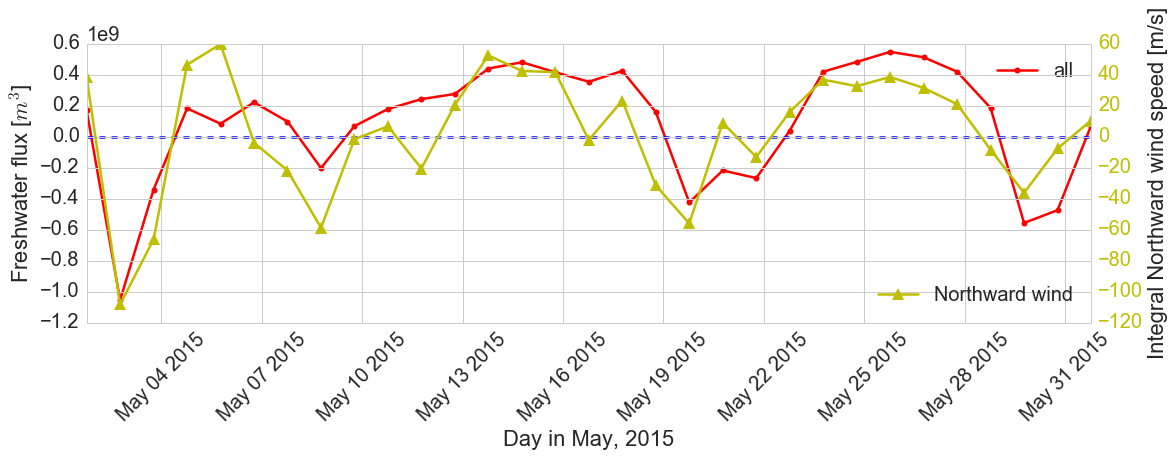

In [37]:
## daily integral of northward wind 
fig,ax = plt.subplots(1,1,figsize = (18,5))
ax.plot(t1,inte_weak_May['May2015combineall'],'r.-',markersize = 12,label ='all')
ax.legend(loc = 'best')
ax.plot([t1[0],t1[-1]],[0,0],'b--')
ax.set_ylabel('Freshwater flux [$m^3$]')
ax.set_xlabel('Day in May, 2015')

ax2 = ax.twinx()
ax2.plot(t1,v_inte,'y^-',markersize = 12,label = 'Northward wind')
ax2.legend(loc = 'best')
ax2.set_ylabel('Integral Northward wind speed [m/s]')
for tl in ax2.get_yticklabels():
    tl.set_color('y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45 )
plt.show()

In [28]:
t1 = [datetime.datetime(2015,5,d,18,30) for d in np.arange(1,32,1)]
t2 = [datetime.datetime(2015,5,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24,6)]

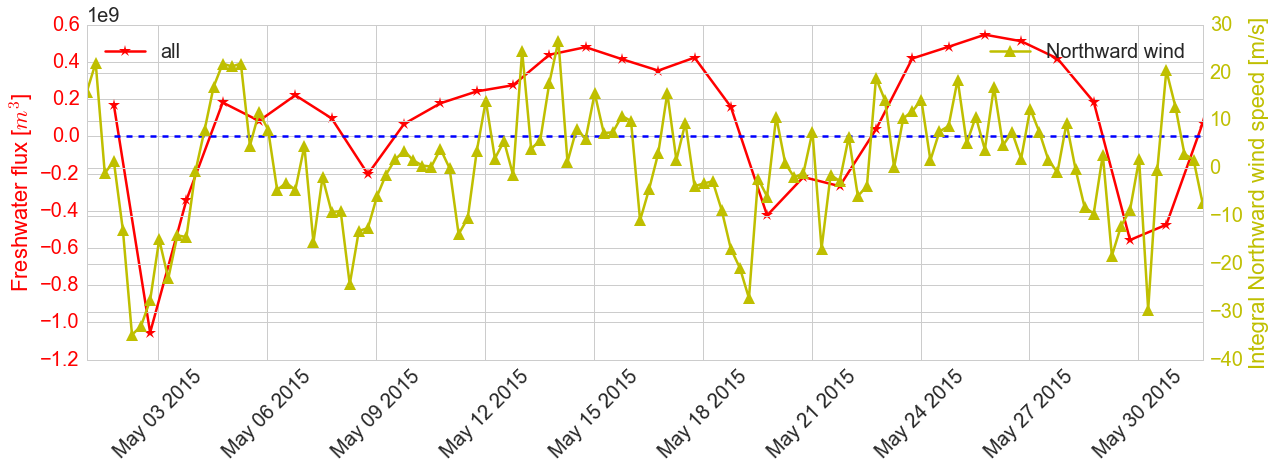

In [33]:
## 6hrs integral of northward wind
fig,ax = plt.subplots(1,1,figsize = (20,6))
ax.plot(t1,inte_weak_May['May2015combineall'],'r*-',markersize = 12,label ='all')
ax.legend(loc = 2)
ax.plot([t1[0],t1[-1]],[0,0],'b--')
ax.set_ylabel('Freshwater flux [$m^3$]',color = 'r')
for tl in ax.get_yticklabels():
    tl.set_color('r')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(t2,v_inte_6hrs,'y^-',markersize = 12,label = 'Northward wind')
ax2.legend(loc = 1)
ax2.set_ylabel('Integral Northward wind speed [m/s]',color = 'y')
for tl in ax2.get_yticklabels():
    tl.set_color('y')
plt.show()

* I think from 6hrs northward wind component integral, on May 18 plus last 6 hours of May 17, wind all going south, the freshwater flux on May 18 still north, so the delay is 1 day and 6 hrs. Another example, on May 6 and 7, wind is going south, but the flux on both days are northward, so this delay is 2 days.